# `qp` Demo

_Alex Malz & Phil Marshall_

In this notebook we use the `qp` module to approximate some simple, standard, 1-D PDFs using sets of quantiles, samples, and histograms, and assess their relative accuracy. We also show how such analyses can be extended to use "composite" PDFs made up of mixtures of standard distributions.

### Requirements

To run `qp`, you will need to first install the module. 

In [1]:
import numpy as np
import scipy.stats as sps
import scipy.interpolate as spi

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import qp

## The `qp.PDF` Class

This is the basic element of `qp` - an object representing a probability density function. This class is stored in the module `pdf.py`.  The PDF must be initialized with some representation of the distribution.

In [2]:
# ! cat qp/pdf.py
#P = qp.PDF(vb=True)

## Approximating a Gaussian

Let's summon a PDF object, and initialize it with a standard function - a Gaussian.

<class 'scipy.stats._distn_infrastructure.rv_frozen'>


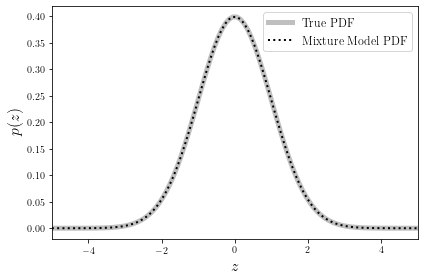

In [3]:
dist = sps.norm(loc=0, scale=1)
print(type(dist))
demo_limits = (-5., 5.)
P = qp.PDF(funcform=dist, limits=demo_limits)
P.plot()

### Samples

Let's sample the PDF to see how it looks.  When we plot the `PDF` object, both the true and sampled distributions are displayed.

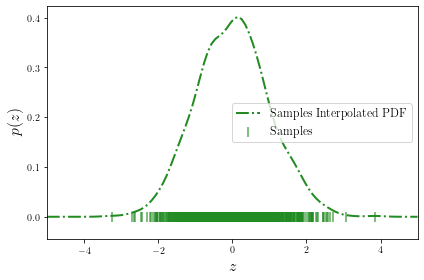

In [4]:
np.random.seed(42)

samples = P.sample(1000, using='mix_mod', vb=False)
S = qp.PDF(samples=samples, limits=demo_limits)
S.plot()

### Quantile Parametrization

Now, let's compute a set of evenly spaced quantiles. These will be carried by the `PDF` object as `p.quantiles`.  We also demonstrate the initialization of a `PDF` object with quantiles and no truth function.

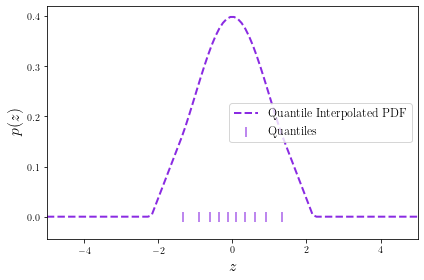

In [5]:
quantiles = P.quantize(N=10)
Q = qp.PDF(quantiles=quantiles, limits=demo_limits)
Q.plot()

### Histogram Parametrization

Let's also compute a histogram representation, that will be carried by the `PDF` object as `p.histogram`. The values in each bin are the integrals of the PDF over the range defined by bin ends. We can also initialize a `PDF` object with a histogram and no truth function.

histogram


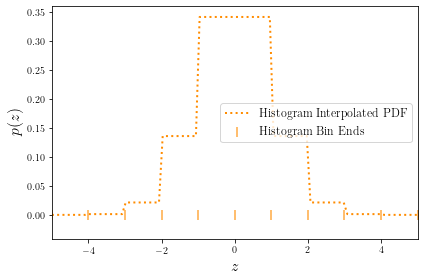

In [6]:
histogram = P.histogramize(N=10, binrange=demo_limits)
H = qp.PDF(histogram=histogram, limits=demo_limits)
H.plot()
print (H.truth)

### Evaluating the Approximate PDF by Interpolation

Once we have chosen a parametrization to approximate the PDF with, we can evaluate the approximate PDF at any point by interpolation (or extrapolation). `qp` uses [`scipy.intepolate.interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) to do this, with `linear` as the default interpolation scheme. (Most other options do not enable extrapolation, `nearest` being the exception.)

Let's test this interpolation by evaluating an approximation at a single point using the quantile parametrization.

In [7]:
print (P.approximate(np.array([0.314]), using='quantiles'))

(array([0.314]), array([0.37975203]))


In [8]:
P.mix_mod

(We can also integrate any approximation.)

In [9]:
print (P.integrate([0., 1.], using='quantiles'))

0.3416628453054795


We can also interpolate the function onto an evenly spaced grid with points within and out of the quantile range, as follows:  

In [10]:
grid = np.linspace(-3., 3., 100)
gridded = P.approximate(grid, using='quantiles')

We can also change the interpolation scheme:

In [11]:
print (P.scheme)
print (P.approximate(np.array([0.314]), using='quantiles', scheme='nearest'))
print (P.scheme)

linear
(array([0.314]), array([0.37975203]))
nearest


### The "Evaluated" or "Gridded" Parametrization

A `qp.PDF` object may also be initialized with a parametrization of a function evaluated on a grid. This is also what is produced by the `qp.PDF.approximate()` method. So, let's take the output of a `qp.PDF` approximation evaluation, and use it to instantiate a new `qp.PDF` object. Note that the `evaluate` method can be used to return PDF evaluations from either the true PDF or one of its approximations, via the `using` keyword argument.

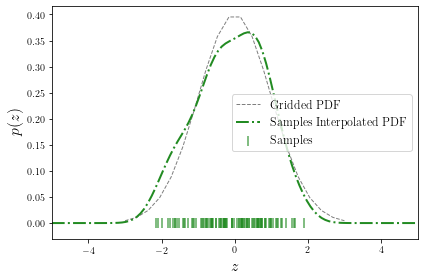

In [12]:
grid = np.linspace(-3., 3., 20)
gridded = P.evaluate(grid, using='mix_mod', vb=False)

G = qp.PDF(gridded=gridded, limits=demo_limits)
G.sample(100, vb=False)
G.plot()

Let's unpack this a little. The `G` PDF object has an attribute `G.gridded` which contains the initial gridded function. This lookup table is used when making further approximations. To check this, let's look at whether this `G` PDF object knows what the _true_ PDF is, which approximation it's going to use, and then how it performs at making a new approximation to the PDF on a coarser grid:

In [13]:
print (G.truth)

gridded


In [14]:
print (G.last,'approximation, ', G.scheme, 'interpolation')

samples approximation,  linear interpolation


In [15]:
# 10-point grid for a coarse approximation:
coarse_grid = np.linspace(-3.5, 3.5, 10)
coarse_evaluation = G.approximate(coarse_grid, using='gridded')
print (coarse_evaluation)

(array([-3.5       , -2.72222222, -1.94444444, -1.16666667, -0.38888889,
        0.38888889,  1.16666667,  1.94444444,  2.72222222,  3.5       ]), array([2.22044605e-16, 1.01276268e-02, 6.23293197e-02, 2.03331828e-01,
       3.67719426e-01, 3.67719426e-01, 2.03331828e-01, 6.23293197e-02,
       1.01276268e-02, 2.22044605e-16]))


### Mixture Model Fit

We can fit a parametric mixture model to samples from any parametrization.  Currently, only a Gaussian mixture model is supported.

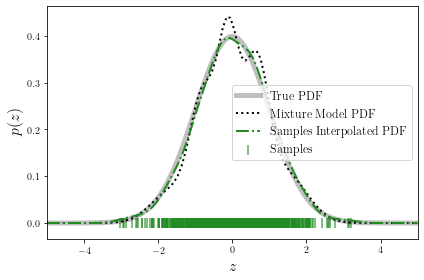

In [16]:
MM = qp.PDF(funcform=dist, limits=demo_limits)
MM.sample(1000, vb=False)
MM.mix_mod_fit(n_components=5)
MM.plot()

## Comparing Parametrizations

`qp` supports both qualitative and quantitative comparisons between different distributions, across parametrizations.

### Qualitative Comparisons: Plotting

Let's visualize the PDF object in order to compare the truth and the approximations.  The solid, black line shows the true PDF evaluated between the bounds.  The green rugplot shows the locations of the 1000 samples we took.  The vertical, dotted, blue lines show the percentiles we asked for, and the hotizontal, dotted, red lines show the 10 equally spaced bins we asked for.  Note that the quantiles refer to the probability distribution *between the bounds*, because we are not able to integrate numerically over an infinite range. Interpolations of each parametrization are given as dashed lines in their corresponding colors.  Note that the interpolations of the quantile and histogram parametrizations are so close to each other that the difference is almost imperceptible!

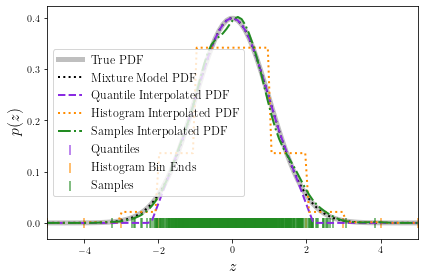

In [17]:
P.plot()

### Quantitative Comparisons

In [18]:
symm_lims = np.array([-1., 1.])
all_lims = [symm_lims, 2.*symm_lims, 3.*symm_lims]

Next, let's compare the different parametrizations to the truth using the Kullback-Leibler Divergence (KLD).  The KLD is a measure of how close two probability distributions are to one another -- a smaller value indicates closer agreement.  It is measured in units of bits of information, the information lost in going from the second distribution to the first distribution.  The KLD calculator here takes in a shared grid upon which to evaluate the true distribution and the interpolated approximation of that distribution and returns the KLD of the approximation relative to the truth, which is not in general the same as the KLD of the truth relative to the approximation.  Below, we'll calculate the KLD of the approximation relative to the truth over different ranges, showing that it increases as it includes areas where the true distribution and interpolated distributions diverge.

In [19]:
for PDF in [Q, H, S]:
    D = []
    for lims in all_lims:
        D.append(qp.metrics.calculate_kld(P, PDF, limits=lims, vb=False))
    print(PDF.truth+' approximation: KLD over 1, 2, 3, sigma ranges = '+str(D))

quantiles approximation: KLD over 1, 2, 3, sigma ranges = [0.011127278513903957, 0.04015606972181256, 1.1315894452070825]
histogram approximation: KLD over 1, 2, 3, sigma ranges = [0.0, 0.0, 0.0]
samples approximation: KLD over 1, 2, 3, sigma ranges = [0.011582778082399102, 0.02948745210726375, 0.040287719114674075]


Holy smokes, does the quantile approximation blow everything else out of the water, thanks to using spline interpolation.

The progression of KLD values should follow that of the root mean square error (RMSE), another measure of how close two functions are to one another.  The RMSE also increases as it includes areas where the true distribution and interpolated distribution diverge.  Unlike the KLD, the RMSE is symmetric, meaning the distance measured is not that of one distribution from the other but of the symmetric distance between them.

In [20]:
for PDF in [Q, H, S]:
    D = []
    for lims in all_lims:
        D.append(qp.metrics.calculate_rmse(P, PDF, limits=lims, vb=False))
    print(PDF.truth+' approximation: RMSE over 1, 2, 3, sigma ranges = '+str(D))

quantiles approximation: RMSE over 1, 2, 3, sigma ranges = [0.048886010133528474, 0.0535081688315159, 0.045301544762496836]
histogram approximation: RMSE over 1, 2, 3, sigma ranges = [0.0, 0.0, 0.0]
samples approximation: RMSE over 1, 2, 3, sigma ranges = [0.04912016010321052, 0.04936073505954505, 0.04135943664485285]


Both the KLD and RMSE metrics suggest that the quantile approximation is better in the high density region, but samples work better when the tails are included. We might expect the answer to the question of which approximation to use to depend on the application, and whether the tails need to be captured or not.

Finally, we can compare the meoments of each approximation and compare those to the moments ofthe true distribution.

In [21]:
pdfs = [P, Q, H, S]
which_moments = range(3)
all_moments = []
for pdf in pdfs:
    moments = []
    for n in which_moments:
        moments.append(qp.metrics.calculate_moment(pdf, n))
    all_moments.append(moments)
    
print('moments: '+str(which_moments))
for i in range(len(pdfs)):
    print(pdfs[i].first+': '+str(all_moments[i]))

moments: range(0, 3)
mix_mod: [0.9999994414547967, -3.649127313398349e-17, 0.9999849286984716]
quantiles: [0.9580945795096312, 2.1240638405074775e-15, 0.7539998777362878]
histogram: [1.0010006868407586, 1.570801213759623e-06, 1.1701406815654898]
samples: [0.9999999986000138, 0.01933204874719945, 1.018778901432694]


The first three moments have an interesting interpretation.  The zeroth moment should always be 1 when calculated over the entire range of redshifts, but the quantile approximation is off by about $7\%$.  We know the first moment in this case is 0, and indeed the evaluation of the first moment for the true distribution deviates from 0 by less than Python's floating point precision.  The samples parametrization has a biased estimate for the first moment to the tune of $2\%$.  The second moment for the true distribution is 1, and the quantile parametrization (and, to a lesser extent, the histogram parametrization) fails to provide a good estimate of it.

## Advanced Usage

### Composite PDFs

In addition to individual `scipy.stats.rv_continuous` objects, `qp` can be initialized with true distributions that are linear combinations of `scipy.stats.rv_continuous` objects.  To do this, one must create the component distributions and specify their relative weights.  This can be done by running `qp.PDF.mix_mod_fit()` on an existing `qp.PDF` object once samples have been calculated, or it can be done by hand.

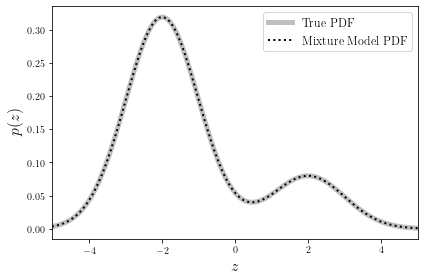

In [22]:
component_1 = {}
component_1['function'] = sps.norm(loc=-2., scale=1.)
component_1['coefficient'] = 4.
component_2 = {}
component_2['function'] = sps.norm(loc=2., scale=1.)
component_2['coefficient'] = 1.
dist_info = [component_1, component_2]

composite_lims = (-5., 5.)

C_dist = qp.composite(dist_info)
C = qp.PDF(funcform=C_dist, limits=composite_lims)
C.plot()

We can calculate the quantiles for such a distribution.

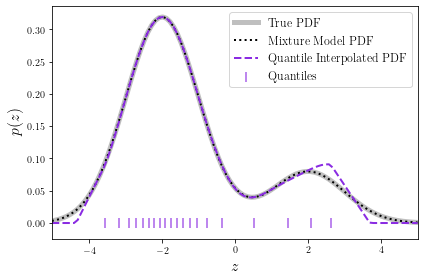

In [23]:
Cq = qp.PDF(funcform=C_dist, limits = composite_lims)
Cq.quantize(N=20, limits=composite_lims, vb=False)
Cq.plot()

Similarly, the histogram parametrization is also supported for composite PDFs.

Calculating histogram:  [-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5  5. ]
Result:  (array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
        0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]), array([0.00778614, 0.02650052, 0.0705866 , 0.14715564, 0.24013706,
       0.30676535, 0.30683452, 0.24058333, 0.14910206, 0.07721173,
       0.04414717, 0.04457502, 0.061824  , 0.07701047, 0.07673381,
       0.06003894, 0.03678931, 0.01764668, 0.00662513, 0.00194653]))


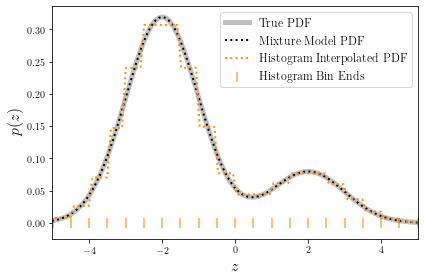

In [24]:
Ch = qp.PDF(funcform=C_dist, limits = composite_lims)
Ch.histogramize(N=20, binrange=composite_lims, vb=True)
Ch.plot()

Finally, samples from this distribution may also be taken, and a PDF may be reconstructed from them.  Note: this uses [`scipy.stats.gaussian_kde`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html), which determines its bandwidth/kernel size using Scott's Rule, Silverman's Rule, a fixed bandwidth, or a callable function that returns a bandwidth.

ValueError: points have dimension 100, dataset has dimension 1

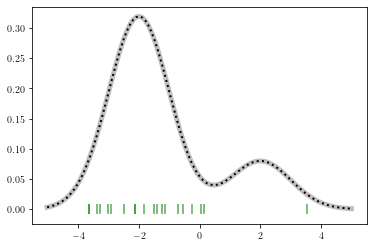

In [25]:
Cs = qp.PDF(funcform=C_dist, limits = composite_lims)
Cs.sample(N=20, using='mix_mod', vb=False)
Cs.plot()

In [26]:
qD = qp.metrics.calculate_kld(C, Cq, limits=composite_lims, dx=0.001, vb=True)
hD = qp.metrics.calculate_kld(C, Ch, limits=composite_lims, dx=0.001, vb=True)
sD = qp.metrics.calculate_kld(C, Cs, limits=composite_lims, dx=0.001, vb=True)
print(qD, hD, sD)

Evaluating the fitted mixture model distribution.
Evaluating the fitted mixture model distribution.
Evaluating the fitted mixture model distribution.
0.4671623057388055 0.008088439968717755 0.18701060822029456


### PDF Ensembles

`qp` also includes infrastructure for handling ensembles of `PDF` objects with shared metaparameters, such as histogram bin ends, but unique per-object parameters, such as histogram bin heights.  A `qp.Ensemble` object takes as input the number of items in the ensemble and, optionally, a list, with contents corresponding to one of the built-in formats.

Let's demonstrate on PDFs with a functional form, which means the list of information for each member of the ensemble is `scipy.stats.rv_continuous` or `qp.composite` objects.

In [27]:
N = 10
in_dists = []
for i in range(N):
    dist = sps.norm(loc=sps.uniform.rvs(), scale=sps.uniform.rvs())
    in_dists.append(dist)
    
E = qp.Ensemble(N, funcform=in_dists, vb=True) 

made the pool of 6 in 0.028530684000003248
made the catalog in 0.03633169500000122
Calculating 9 quantiles: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Resulting 9 quantiles: (array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), array([0.24167891, 0.48011678, 0.65204727, 0.79895552, 0.93626714,
       1.07357875, 1.22048701, 1.39241749, 1.63085537]))
input quantiles are [0.24167891 0.48011678 0.65204727 0.79895552 0.93626714 1.07357875
 1.22048701 1.39241749 1.63085537]Calculating 9 quantiles: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

Resulting 9 quantiles: (array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), array([0.65709029, 0.75408775, 0.82402975, 0.88379261, 0.93965151,
       0.99551042, 1.05527327, 1.12521527, 1.22221273]))input shape: (9, 8), output shape: (18, 18)

complete evaluated quantile PDF: (array([-0.23519684,  0.24167891,  0.48011678,  0.48011678,  0.65204727,
        0.65204727,  0.79895552,  0.79895552,  0.93626714,  0.93626714,
        1.07357875,  1.07357875,  1.2204870

Created a k=`4`B-spline interpolator for the quantiles parametrization.
divided into (array([46, 47, 48, 49]), array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]), array([63, 64, 65, 66]))
Calculating 9 quantiles: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
input shape: (9, 8), output shape: (18, 18)
Created a k=`4`B-spline interpolator for the quantiles parametrization.
evaluated inside (array([0.55555556, 0.65656566, 0.75757576, 0.85858586, 0.95959596]), array([1.28788627, 1.72506557, 1.85176752, 1.59295722, 1.09803452]))
Resulting 9 quantiles: (array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), array([0.78202054, 0.81910725, 0.84584937, 0.86869953, 0.89005703,
       0.91141452, 0.93426468, 0.9610068 , 0.99809351]))complete evaluated quantile PDF: (array([0.03594668, 0.3237004 , 0.46757726, 0.46757726, 0.5713226 ,
       0.5713226 , 0.65996916, 0.65996916, 0.74282497, 0.74282497,
       0.82568079, 0.82568079, 0.91432735, 0.91432735, 1.01807269,
       1.01807269, 1.16194955, 1

       0.24866518, 0.21682346]))
evaluated inside (array([0.25252525, 0.35353535, 0.45454545, 0.55555556, 0.65656566,
       0.75757576, 0.85858586, 0.95959596, 1.06060606, 1.16161616,
       1.26262626, 1.36363636, 1.46464646]), array([0.42412498, 0.51690141, 0.60584365, 0.68304285, 0.74079776,
       0.77282717, 0.77555359, 0.74867101, 0.69518996, 0.62096562,
       0.53357031, 0.44089914, 0.35092118]))
order is 5

evaluated below (array([-0.95959596, -0.85858586, -0.75757576, -0.65656566, -0.55555556,
       -0.45454545, -0.35353535]), array([0.0255429 , 0.05273567, 0.07992845, 0.10712122, 0.13431399,
       0.16150677, 0.18869954]))divided into (array([33, 34, 35, 36, 37, 38, 39, 40, 41]), array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66]), array([67, 68, 69, 70, 71, 72, 73, 74, 75]))evaluated below (array([-0.25252525, -0.15151515, -0.05050505,  0.05050505,  0.15151515]), array([0.02919974, 0.1059378 , 0.18267587, 0.2

As with individual `qp.PDF` objects, we can evaluate the PDFs at given points, convert to other formats, and integrate.

In [28]:
eval_range = np.linspace(-5., 5., 100)
E.evaluate(eval_range, using='mix_mod', vb=False)

(array([-5.        , -4.8989899 , -4.7979798 , -4.6969697 , -4.5959596 ,
        -4.49494949, -4.39393939, -4.29292929, -4.19191919, -4.09090909,
        -3.98989899, -3.88888889, -3.78787879, -3.68686869, -3.58585859,
        -3.48484848, -3.38383838, -3.28282828, -3.18181818, -3.08080808,
        -2.97979798, -2.87878788, -2.77777778, -2.67676768, -2.57575758,
        -2.47474747, -2.37373737, -2.27272727, -2.17171717, -2.07070707,
        -1.96969697, -1.86868687, -1.76767677, -1.66666667, -1.56565657,
        -1.46464646, -1.36363636, -1.26262626, -1.16161616, -1.06060606,
        -0.95959596, -0.85858586, -0.75757576, -0.65656566, -0.55555556,
        -0.45454545, -0.35353535, -0.25252525, -0.15151515, -0.05050505,
         0.05050505,  0.15151515,  0.25252525,  0.35353535,  0.45454545,
         0.55555556,  0.65656566,  0.75757576,  0.85858586,  0.95959596,
         1.06060606,  1.16161616,  1.26262626,  1.36363636,  1.46464646,
         1.56565657,  1.66666667,  1.76767677,  1.8

In [29]:
E.quantize(N=10)

(array([0.09090909, 0.18181818, 0.27272727, 0.36363636, 0.45454545,
        0.54545455, 0.63636364, 0.72727273, 0.81818182, 0.90909091]),
 array([[ 2.12614058e-01,  4.43891991e-01,  6.08587882e-01,
          7.47245014e-01,  8.74379843e-01,  9.98154436e-01,
          1.12528926e+00,  1.26394640e+00,  1.42864229e+00,
          1.65992022e+00],
        [ 6.45266593e-01,  7.39351365e-01,  8.06350301e-01,
          8.62756567e-01,  9.14475516e-01,  9.64827507e-01,
          1.01654646e+00,  1.07295272e+00,  1.13995166e+00,
          1.23403643e+00],
        [-9.84112399e-02,  1.64981181e-01,  3.52546197e-01,
          5.10456799e-01,  6.55245149e-01,  7.96206671e-01,
          9.40995022e-01,  1.09890562e+00,  1.28647064e+00,
          1.54986306e+00],
        [ 4.52788477e-01,  5.44391520e-01,  6.09623185e-01,
          6.64541590e-01,  7.14896317e-01,  7.63920143e-01,
          8.14274870e-01,  8.69193275e-01,  9.34424940e-01,
          1.02602798e+00],
        [ 2.20717403e-05,  2.12545

In [30]:
E.integrate(demo_limits, using='mix_mod')

[0.9999999999996347,
 0.9999999999996676,
 0.9999999999975192,
 0.9999999999996676,
 0.9999999999996666,
 0.999999999999667,
 0.9999999999996682,
 0.9999994409648089,
 0.9999999999996663,
 0.9999976538267471]

Previous versions of `qp` included a built-in function for "stacking" the member PDFs of a `qp.Ensemble` object.  This functionality has been removed to discourage use of this procedure in science applications.  However, we provide a simple function one may use should this functionality be desired.

In [31]:
def stack(ensemble, loc, using, vb=True):
    """
    Produces an average of the PDFs in the ensemble

    Parameters
    ----------
    ensemble: qp.Ensemble
        the ensemble of PDFs to stack
    loc: ndarray, float or float
        location(s) at which to evaluate the PDFs
    using: string
        which parametrization to use for the approximation
    vb: boolean
        report on progress

    Returns
    -------
    stacked: tuple, ndarray, float
        pair of arrays for locations where approximations were evaluated
        and the values of the stacked PDFs at those points
    """
    evaluated = ensemble.evaluate(loc, using=using, norm=True, vb=vb)
    stack = np.mean(evaluated[1], axis=0)
    stacked = (evaluated[0], stack)
    return stacked

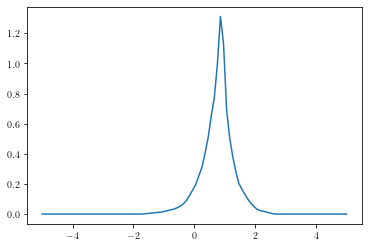

In [32]:
stacked = stack(E, eval_range, using='quantiles')
plt.plot(stacked[0], stacked[-1])